In [ ]:
import jax.numpy as np
import numpy as onp
from jax import vmap, grad, random, jit
from jax.experimental import stax, optimizers
from jax.experimental.stax import Dense, Conv, Relu, MaxPool, Flatten, Softmax
from jax.nn import one_hot

import itertools
from functools import partial
from tqdm import trange
from torch.utils import data
import torchvision as tv
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [ ]:
# Some helper functions for visualization
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_filters(conv, shape, title):
    plt.figure(figsize=(5,4))
    cnt=0
    m, n = shape
    for i in range(m):
      for j in range(n):
          cnt+=1
          plt.subplot(m,n,cnt)   
          plt.imshow(conv[0,:,:,cnt]) 
          plt.axis('off')
    fig = plt.gcf()
    fig.suptitle(title)

In [ ]:
# Architecture
def CNN():
    init, apply = stax.serial(Conv(6, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Conv(12, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Conv(24, (5, 5), (1, 1), padding="SAME"),
                              Relu, Flatten,
                              Fourier,
                              Dense(256), Relu, 
                              Dense(128), Relu, 
                              Dense(64), Relu, 
                              Dense(10), Softmax)
    return init, apply

In [ ]:
class CNNclassifier:
    # Initialize the class
    def __init__(self, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = CNN()
        _, params = self.net_init(rng_key, (-1, 28, 28, 1))

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        images, labels = batch
        outputs = self.net_apply(params, images)
        loss = -labels*np.log(outputs)
        return np.mean(loss)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [ ]:
# Training data
train = tv.datasets.MNIST('./', download=True, train=True)
train_images = np.array(train.data.numpy())
train_labels = np.array(train.targets.numpy())

# Input shape should be (NxWxHxC) and normalized to [0,1]
train_images = train_images[:,:,:,np.newaxis]/255.
# Labels should be a one-hot vector
num_classes = train_labels.max()+1
train_labels = one_hot(train_labels, num_classes)

# Create data iteraror
train_dataset = DataGenerator(train_images, train_labels, batch_size=128)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Initialize model
model = CNNclassifier()

100%|██████████| 5000/5000 [00:33<00:00, 149.32it/s, Loss=0.0007902224]


Text(0, 0.5, 'Loss')

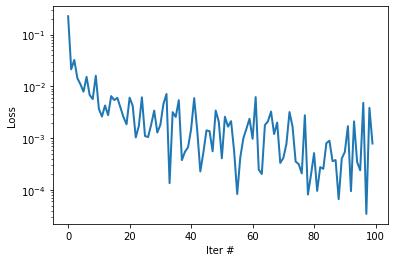

In [ ]:
# Train model
model.train(train_dataset, nIter=5000)
opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
# Test data
test = tv.datasets.MNIST('./', download=True, train=False)
test_images = np.array(test.data.numpy())
test_labels = np.array(test.targets.numpy())

# Input shape should be (NxWxHxC) and normalized to [0,1]
test_images = test_images[:,:,:,np.newaxis]/255.
test_labels = one_hot(test_labels, num_classes)

# Create data iteraror
test_dataset = DataGenerator(test_images, test_labels, batch_size=6)
test_data = iter(test_dataset)

In [ ]:
# Compute classification accuracy on the entire test data-set
@jit
def accuracy(params, batch):
    images, labels = batch
    outputs = model.predict(params, images)
    pred_class = np.argmax(outputs,1)
    true_class = np.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy(opt_params, (test_images, test_labels))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 99.0199966430664%


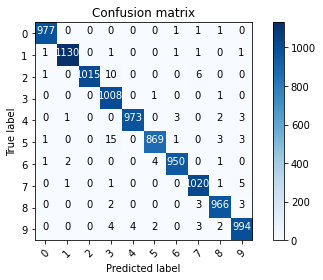

In [ ]:
# Plot the confusion matrix
outputs = model.predict(opt_params, test_images)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(test_labels,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=False)

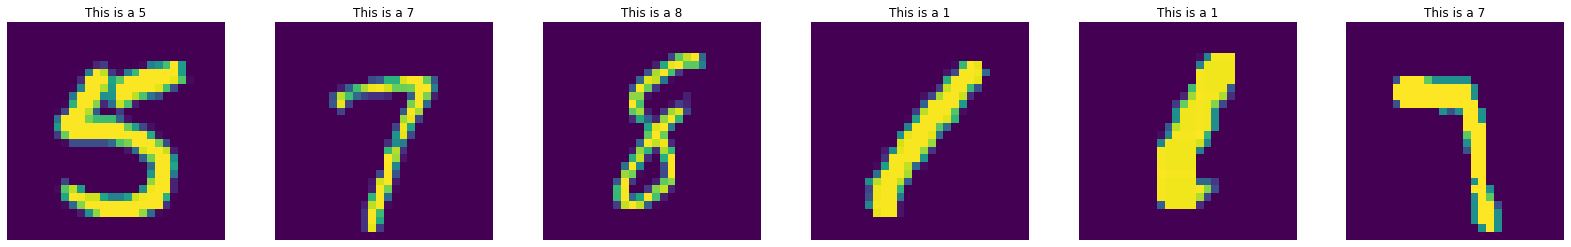

In [ ]:
# Visualize some predictions
batch = next(test_data)
images, labels = batch
plt.figure(figsize=(28,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    outputs = model.predict(opt_params, images[i:i+1,...])
    pred_class = np.argmax(outputs,1)
    plt.imshow(images[i,:,:,0])
    plt.axis('off')
    plt.title('This is a {}'.format(pred_class[0]))

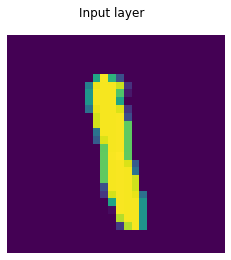

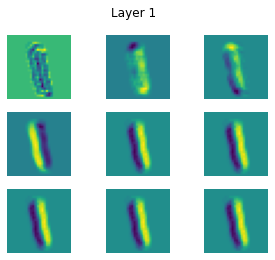

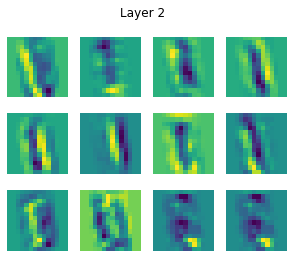

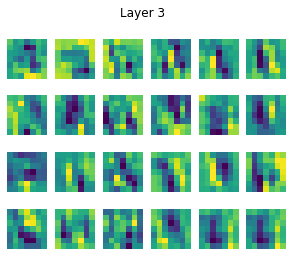

In [ ]:
# Visualize filters in each layer for a random input image
idx = onp.random.randint(test_images.shape[0])
image = test_images[idx:idx+1,...]
# Hidden layer 1
conv1 = Conv(6, (5, 5), (1, 1), padding="SAME")[1](opt_params[0], image)
relu1 = Relu[1](opt_params[1], conv1)
maxpool1 = MaxPool((2, 2), (2, 2))[1](opt_params[2], relu1)
# Hidden layer 2
conv2 = Conv(12, (5, 5), (1, 1), padding="SAME")[1](opt_params[3], maxpool1)
relu2 = Relu[1](opt_params[4], conv2)
maxpool2 = MaxPool((2, 2), (2, 2))[1](opt_params[5], relu2)
# Hidden layer 3
conv3 = Conv(24, (5, 5), (1, 1), padding="SAME")[1](opt_params[6], maxpool2)
relu3 = Relu[1](opt_params[7], conv3)
flatten3 = Flatten[1](opt_params[8], relu3)

# Visualize filters
plot_filters(image, (1,1), 'Input layer')
plot_filters(conv1, (3,3), 'Layer 1')
plot_filters(conv2, (3,4), 'Layer 2')
plot_filters(conv3, (4,6), 'Layer 3')